# <span style="color:green">Evaluation of Satellite Imagery Inputs<br>Used to Create the Hydrsoat "Fused" <br>Land Surface Temperature product.</span>
Erik Anderson &
Tyler Cruickshank

[Project Repository](https://github.com/eriktuck/ea-lst-capstone)

<img src="./hydrosat.jpg" width="600" height="300"/>

## *Note for Reviewer June 27, 2023 --------------------*

We have had unexpected changes to our project.  The project goals have morphed from developing a crop stress indicator and towards evaluating the satellite input data that are used by Hydrosat to create their proprietary high resolution daily Land Surface Temperature product.  We are still developing a process and still figuring out what we will be able to produce for the overall project.

There has been a lot of code developed along the way and not all of it is being used in this notebook, however, we are keeping the code here because we dont know yet what we may end up using and what we will discard.  This notebook version focuses on evaluating the variability of NDVI and LST values that are used as inputs to the daily high resolution LST product.  We have identified errors in the processing of the product and found missing data that has not been properly catalgoued.  We are also finding data outliers that point towards the need for a more robust filtering (or QA/QC) process of the input iagery data.

The notebook, as submitted today, focuses on NDVI from Sentinel 2 and LST in the form of CATD (LST - air temp).  There are other code cells but they have been collapsed.  

### *Conditional , Try/Except*

Most of our code is done on the fly and does not download.  The one or two data files that are needed are small and come in the repo.  So, at the moment I'm not finding many strong applications for conditionals or Try/Except.  I've added a couple conditionals to the STAC login code cell and a couple of try/excepts when I call the create_aoi_image_stack().

# <span style="color:green">Project Overview</span>

<font size="4">Maximizing agricultural productivity is critical for maintaining world food supply and containing food cost.

Modern agribusiness employs targeted technology to <span style="color:lightblue">optimize cropland productivity</span> using modern information and communication technologies at fine spatial resolution (within-field scale). High resolution remotely sensed data of soil conditions and vegetation health provides near real-time information that informs <span style="color:lightblue">adaptive irrigation and fertilization technology</span>. The Normalized Difference Vegetation Index (NDVI) is a commonly used remotely sensed index that provides data on the "greenness" or health of crop vegetation. However, the NDVI index is a lagging indicator of crop stress because water or heat stress occurs prior to the degradation of vegetation greenness.

This project aims to support this effort by exploring the satellite inputs that are used to create a daily Hydrosat high resolution "Fused" Lands Surface Temperature product.

</font>

## <span style="color:green">Project Location</span>

<font size="4">The project is focused on agricultural areas with active farming.  At present, we are extracting data for locations in the San Joaquin Valley, CA and near Ames, Iowa.  In this notebook, we are focused on developing a process for extracting and evaluating time-series data from a point location.  Future notebook iterations may include a spatial analysis that incorporates processes developed from our time-series work.</font>

# <span style="color:green">Data Overview</span></span>

<font size="4">Hydrosat provides a proprietary "fused" thermal infrared land surface temperature (LST) imagery product that is downscaled to 20 m resolution using a combination of MODIS, Sentinel and Landsat imaging platforms.  Hydrosat utilizes a data mining approach for sharpening thermal satellite imagery (DMS) (Gao, F. 2012) and a separate algorithm for interpolating land surface temperature between measurement points (STARFM) (Gao, F 2006). This high resolution fused product is produced daily and presents an added value opportunity for agribusiness.  The same process produces a paired downscaled 20m NDVI fused product.

The data is accessed from a Spatial Temporal Asset Catalog (STAC).  STAC is a specification standard with a unified language to describe geospatial data which allows it to be more easily searchable and queryable. </font>

# <span style="color:green">Notebook Code Overview</span>

<font size="4">At present, this notebook is designed to perform an analysis for a time-series of single specified point.

The backbone of this notebook utilizes the Hydrosat Fusion Hub class.  The class has methods for:
1. Logging in to the STAC.
2. Querying the STAC for specified imagery.
3. Creating a FH Hydrosat object which provides purposeful utility.
4. Extracting pixel data for a defined area of interest (AOI).

We have written additional code to:
1. Extract surface reflectance data from Modis and Sentinel 2 and calculate NDVI.
2. Extract fused LST data products from each imagery component.
3. Plot and examine variations in each satellite component.
4. Extract meteorological data for the time-frame using the HRRR API.

</font>

## <span style="color:green">References</span>

Gao, F. Masek, J. Schwaller, M. Hall, F. 2006. On the Blending of Landsat and MODIS Surface Reflectance: Predicting Landsat Surface Reflectance. IEE Transaction on Geoscience and Remote Sensing Vol 44, No 8.

Gao, F. Kustas, W. Anderson, M. 2012. A Data Mining Approach for Sharpening Thermal Satellite Imagery Over Land. Remote Sensing. doi: 10.3390/rs4113287.

Karnieli, A., Agam, N., Pinker, R., Anderseon, M., Imhoff, M., Gutman, G., Panov, N., Goldberg, A., Use of NDVI and Land Surface Temperature for Drought Assessment: Merits and Limitations.  Journal of Climate. Vol 23. 2010

Y. Erdem , T. Erdem , A.H. Orta & H. Okursoy. Canopy-air temperature differential for potato under different irrigation regimes. Acta Agriculturae Scandinavica Section B-Soil and Plant Science, 2006; 56: 206216


## <span style="color:green">Collaborators </span>

- [Erik Anderson](https://github.com/eriktuck)
- [Tyler Cruickshank](https://github.com/tcruicks)
- [Joe McGlinchy](https://github.com/joemcglinchy)
We thank Joe McGlinchy of Hydrosat for providing project guidance and data access.

In [620]:
import base64
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import os
import pystac
import requests
import xarray as xr
import rioxarray as rxr
import rasterio as rio
import seaborn as sns
import folium 

from datetime import date
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from distutils.command import sdist
from folium import plugins
from matplotlib import pyplot as plt
from pyproj.crs import CRS
from pystac_client import Client
from pprint import pprint
from shapely.geometry import box, mapping, Point, Polygon
from sklearn.linear_model import LinearRegression

# Project specific packages
from FH_Hydrosat import FH_StackedDataset
from FH_Hydrosat import FH_Hydrosat
from herbie import FastHerbie
#import synoptic.services as ss
#from synoptic.services import stations_timeseries

os.environ['USE_PYGEOS'] = '0'

## Functions
This section defines a number of functions for later use. No user editing is required.

In [621]:
# ---------------------------------------------------------------------------------

def stac_tile_search(collection, geom, start_date, end_date):
    """
    Log into STAC and search for a specified image collection.

    Parameters:
    ----------
    collection: list
        List of tiles found in STAC.

    geom: 
        Point location to search.

    start_date, end_date: str
        Dates to search between.

    Returns:
    -------
    """

    search = catalog.search(
        collections = collection,
        intersects = geom,
        datetime = [start_date, end_date],
        max_items = 1000,
    )

    #items = list(search.items()) # for pystac-client >= 0.4.0
    found_items = list(search.get_all_items()) # for pystac-client < 0.4.0

    # Filter out only the newest version of MODIS.
    if collection == 'prepped_inputs_mcd43a4':
        version_str = '061'
        new_list = [i for i in found_items if version_str in i.id]
        found_items = new_list

    found_items.reverse() # make the results ascending in time

    num_tiles = len(found_items)
    print ("    Colllection: {} \n".format(collection))
    print ("    Number of fusion tiles available: {}".format(num_tiles))
    print ("\n")

    return (found_items, num_tiles)

# ---------------------------------------------------------------------------------

def create_clip_polygon(geom, ds, buffer):
    """
    Create a polygon that we will use for clipping the big dataset.

    Parameters:
    ----------
    geom: dict
        Dictionary of lat and lon of center point of AOI.

    Returns:
    -------
    poly: dataframe
        Contains geometry of a square to be used for clipping.
    """
    # Using the point coords defined earlier, create a df with the point geometry.
    p_geom = Point(geom['coordinates'][0], geom['coordinates'][1])
    point_df = gpd.GeoDataFrame({'geometry':[p_geom]}, crs=CRS.from_epsg(4326))

    # Define a buffer size (for each side of the point.
    # Reproject the point df and create the new polygon.
    raster_crs = CRS.from_wkt(ds.spatial_ref.crs_wkt)
    buffer_dist = buffer # 1km in local UTM zone

    # create a square buffer
    poly_df = point_df.to_crs(raster_crs).buffer(buffer_dist, cap_style = 3) 

    return(poly_df)

# ---------------------------------------------------------------------------------

def create_aoi_image_stack(asset, items, num_tiles, geom, buffer):
    '''
    Gets images, stacks them and sorts them by date and clips them down to a smaller
    AOI size.

    Parameters:
    -----------
    itmes: list 
        List of available images.
    num_tiles: int
        Number of tiles to download (days)
    asset: str
        Name of asset to get.
    geom: x,y coords
        Coordinates around which to build a polygon
    buffer: int
        Buffer around the x,y for creating the AOI rectangele.  In meters.

    Returns:
    --------
    aoi_stack_ds: dataset as FH_StackedDataset object.
        Stack of images clipped to AOI.

    '''
    images = FH_Hydrosat(items[:num_tiles], asset=asset)

    # Stacks all the files into a dataset and then return a FH_StackedDataset object.
    stacked_images = images.stack()
    # Sort the dataset by time.
    ds = stacked_images.ds.sortby('time')

    # Create polygon Area of Interest (AOI for which to sample.).
    clip_poly_df = create_clip_polygon(geom, ds, buffer=buffer)
    # Use AOI polygon to clip the dataset dwon to size and make it into a FH_StackedDataset object.
    clipped = FH_StackedDataset(ds.rio.clip(clip_poly_df.geometry))
    aoi_stack_ds = clipped.ds

    return (aoi_stack_ds, clip_poly_df)

# ---------------------------------------------------------------------------------

def extract_time_series(items, asset, bbox, tol, pad, band, var_name):

    '''
    Uses FH_Hydrosat class method point_time_series_from_items()
    to extract only a time-series.

    Parameters:
    -----------
    items: list
        Image items returned from STAC search.
    bbox: 
        Bounding box of coordinates for seacrh site.
    tol: int
        A search parameter in meters for finding point data.
    var_name: str
        Dataframe column name for data extracted.
    asset: str
        Search parameter for type of asset to be searched.
    
    Returns:
    -------
    lst_df: dataframe
        Dataframe containing date time series.
    '''
    # Sample the LST items.
    lst_res = FH_Hydrosat(items, asset=asset)

    # Set the point for time-series extraction.
    point_wgs84 = Point(box(*bbox).centroid.x, box(*bbox).centroid.y)
    
    # Extract time-series data using function.
    band = int(band) # band needs to be an int because it comes in as a string.
    lst_k  = lst_res.point_time_series_from_items(point_wgs84, tol=tol, nproc=6, band=band) 

    # Create a datetime dataframe
    lst_dt = lst_res.datetime
    lst_df = pd.DataFrame({var_name: lst_k,
                       'datetime': pd.to_datetime(lst_dt)}).sort_values(by='datetime')
    
    # Get the date in the correct/consistent format.
    lst_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in lst_df['datetime']]
    lst_df['date'] = pd.to_datetime(lst_df['date'])
    lst_df.drop(columns='datetime', inplace=True)
    lst_df.set_index('date', drop=True, inplace=True)
    
    return (lst_df)

# ---------------------------------------------------------------------------------

def get_hrrr_point_data(lat, lon, start, days):
    ''' 
    Fetch met data from the HRRR model system.
    Herbie package needs to be installed:
    https://herbie.readthedocs.io/en/stable/
    ${HOME}/.config/herbie/config.toml

    Parameters:
    ----------
    lat, lon: float
        Coords from which to pull grid cell data. 
    start: str
        This is the start date for which data will be retrieved.
    days: int
        Number of days of data to retrieve.

    Return:
    -------
    ds_point: xarray dataset
        Met data for specified point.
    '''
 
    # Create a range of dates
    DATES = pd.date_range(
        start=start,
        periods=days,
        freq="1D",
    )

    # Define forecast lead time (or analysis).
    fxx = range(0, 1)

    # -----------------------------------------------
    # For long time-series analyses
    # -----------------------------------------------
    FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
    FH.download("TMP:2 m")
    ds = FH.xarray("TMP:2 m", remove_grib=False)
    # -----------------------------------------------
    # For real-time fetching of HRRR data.
    # -----------------------------------------------
    # Make FastHerbie Object.
    # FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
    # Read a subset of the data with xarray.
    # ds = FH.xarray("TMP:2 m", remove_grib=False)
    # -----------------------------------------------

    # Get data values nearest single point
    ds_point = ds.herbie.nearest_points(points=(lon, lat))
   
    return (ds_point)

# ---------------------------------------------------------------------------------

def read_ameriflux(data_path):

    print ('Reading file {}'.format(data_path))
    
    df = pd.read_csv(data_path, header=0, na_values=[-9999.000000])

    # Save value column names
    value_cols = df.columns[2:]

    # Convert timestamp objects
    df['start'] = df['TIMESTAMP_START'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M.0")
        )
    df['end'] = df['TIMESTAMP_END'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M.0")
        )

    # Convert obs to UTC time.txt.
    # # UTC_OFFSET is a global var.
    df['start'] = df['start'] + timedelta(hours=UTC_OFFSET)
    df['end'] = df['end'] + timedelta(hours=UTC_OFFSET)
    df['start'] = df['start'].dt.tz_localize('UTC')
    df['end'] = df['end'].dt.tz_localize('UTC')

    # Drop NA
    df = df.dropna(subset=value_cols, how='all')

    df = df.set_index('start')
    col_order = (['end', 'TIMESTAMP_START', 'TIMESTAMP_END'] 
                 + value_cols.to_list())
    df = df[col_order]

    return df

# ---------------------------------------------------------------------------------
def get_ameriflux_met_dates(start_dt, end_dt, image_dates):
    
    df3 = pd.DataFrame()
    
    met_path = os.path.join(data_path, 'US-Bi2_HH_201704270000_202301010000.csv')
    met_df = read_ameriflux(met_path)
    ta_df = met_df['TA'] + 273

    df1 = ta_df.loc[start_dt:end_dt]

    df1.index = pd.to_datetime(df1.index)

    match_timestamp = "18:30:00"
    df2 = df1.loc[df1.index.strftime("%H:%M:%S") == match_timestamp]
    df3 = df2.to_frame()

    df3['date'] = df3.index.strftime('%Y-%m-%d')
    df3.set_index('date', inplace=True, append=True) 
  
    temp_df = df3[df3.index.get_level_values('date').isin(image_dates.index)]
    temp_df.reset_index( level = [0], inplace=True)

    return (temp_df )


## Login to the Hydrosat Fusion Hub
The Hydrosat Fusion Hub serves Land Surface Temperature (LST) data via a spatiotemporal asset catalog (STAC) API.

In [622]:
# Open credentials file.
with open('../secrets/creds.json') as f:
    creds = json.loads(f.read())

# Endecode the `username:password` combination 
# and use it to authorize access to the STAC API given by the `cat_url` 
# endpoint.userpass = f"{creds['username']}:{creds['password']}"
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

if not catalog.id == 'stac-server':
    print ("You have failed to log into the STAC server\n")
else: print ("You are succesfully logged in to the STAC server and you can now begin STAC queries.\n")

You are succesfully logged in to the STAC server and you can now begin STAC queries.



## Set up Analysis
To change the area of interest or start and end dates of the analysis, edit the cell below.

In [623]:
# ---------------------------------------------------------------------------
# USER EDITS REQUIRED -------------------------------------------------------
# ---------------------------------------------------------------------------

analysis = 'Corn'

# Want met obs in UTC time to match satellites.
UTC_OFFSET = 7

# Insitu point locations
insitu_met_points = {
    'Corn': [38.1091, -121.5351],
    'Alfalfa': [38.0992, -121.4993]
}

# Center point of crop fields.
crop_center_points = {
    'Corn': [-121.5360, 38.1095],
    'Alfalfa': [-121.5015, 38.0994],
    'Ames': [-93.701, 42.000],
}

# Set dates for corn where ndvi >= 0.5.
# Dates determined in a diff notebook called
# lst-point-area-comparison-tcruicks-ipynb.
start1 = '2021-05-01T00:00:00Z' 
end1 = '2021-10-31T00:00:00Z'

start2 = '2022-05-01T00:00:00Z' 
end2 = '2022-10-31T00:00:00Z'

# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------

# Define paths to met data
data_path = os.path.join('../data', 'Ameriflux')

if analysis == 'Alfalfa':
    bbox = [-121.5027, 38.0986, -121.5003, 38.1000]
    met_path = os.path.join(data_path, 
                                'US-Bi1_HH_201608130000_202301010000.csv')
    if not os.path.exists(data_path): 
        print ("You do not have the required Ameriflux data file for a {} analysis".format(analysis))

elif analysis == 'Corn':
    bbox = [-121.5365, 38.1098, -121.5355, 38.1091]
    met_path = os.path.join(data_path,
                                'US-Bi2_HH_201704270000_202301010000.csv')
    if not os.path.exists(data_path): 
        print ("You do not have the required Ameriflux data file for a {} analysis".format(analysis))

# Create dict of coords.  Will be used to create a polygon for our AOI.
geom = {'type': 'Point', 'coordinates': crop_center_points[analysis]} 

print ("Analysis setup comlete.\n")

Analysis setup comlete.



### Search for MODIS surface reflectance images.

In [ ]:
# Collection to search for.
collections = ["prepped_inputs_mcd43a4"]

# Search STAC for available images.
(mod_items1, num_tiles1) = stac_tile_search(collections, geom, start1, end1)
(mod_items2, num_tiles2) = stac_tile_search(collections, geom, start2, end2)
mod_items = mod_items1 + mod_items2
num_tiles = num_tiles1 + num_tiles2

print (f"First date: {mod_items[0]}")
print (f"Last date: {mod_items[-1]}")

### Search for Sentinel surface reflectance images.

In [624]:
# Collection to search for.
collections = ["prepped_inputs_s2"]

# Search STAC for available images.
(s2_items1, num_tiles1) = stac_tile_search(collections, geom, start1, end1)
(s2_items2, num_tiles2) = stac_tile_search(collections, geom, start2, end2)
s2_items = s2_items1 + s2_items2
num_s2_tiles = num_tiles1 + num_tiles2

print (f"First date: {s2_items[0]}")
print (f"Last date: {s2_items[-1]}")

    Colllection: ['prepped_inputs_s2'] 

    Number of fusion tiles available: 22


    Colllection: ['prepped_inputs_s2'] 

    Number of fusion tiles available: 34


First date: <Item id=S2_10SFH_median_composite_20210502>
Last date: <Item id=S2_10SFH_median_composite_20221029>


### Extract Sentinel Surface Reflectance for each pixel in the AOI.

In [625]:
# Extract all SR bands from AOI.
try:
    (aoi_stack_ds, clip_poly_df) = create_aoi_image_stack('surface_reflectance', s2_items, num_s2_tiles, geom, 65)
except:
    print ("Your STAC search turned up {} images.".format(num_s2_tiles))
    print ("You'll need to modify your STACsearch parameters.\n")
    
# Pull out NIR and Red bands.
red_aoi_ds = aoi_stack_ds.isel(band=2)
nir_aoi_ds = aoi_stack_ds.isel(band=6)
# Compute NDVI.
ndvi_aoi_ds = (nir_aoi_ds - red_aoi_ds) / (nir_aoi_ds + red_aoi_ds)
# Create a NDVI AOI mean dataset.
mean_ndvi_aoi_ds = ndvi_aoi_ds.mean(dim=["x", "y"])
# Convert dataaset to a dataframe.
df = ndvi_aoi_ds.to_dataframe(name='s2_ndvi')
mean_df = mean_ndvi_aoi_ds.to_dataframe(name='s2_mean_ndvi')

### Get the index and date formats squared away.

In [626]:
# Drop uneeded columns.
df.drop(columns=['spatial_ref'], inplace=True)
mean_df.drop(columns=['spatial_ref'], inplace=True)
# Convert multilevel index to single level.
df = df.reset_index( level = [1 , 2] )
# Want to preserve original timestamp as in own column.
df['datetime'] = df.index
mean_df['datetime'] = mean_df.index

# Set the index to the %Y-%m-%d date format. But ... then we have to convert
# it's format into a datetime format otherwise it remains an object format.
s2_ndvi_df = df.set_index(pd.to_datetime(df.index).strftime('%Y-%m-%d'))
s2_ndvi_df.index = pd.to_datetime(s2_ndvi_df.index)

s2_mean_ndvi_df = mean_df.set_index(pd.to_datetime(mean_df.index).strftime('%Y-%m-%d'))
s2_mean_ndvi_df.index = pd.to_datetime(s2_mean_ndvi_df.index)

### We now have dataframes with NDVI for each pixel in the AOI and mean NDVI for the entire AOI.  Sentinel images are available every 7 days, but we'd like the dataframe to have all days of the year in it.  Doing this will make plotting more convient when we want to compare it to LST which we'll have at a much higher frequency. So we'll create a new df with a complete set of dates for 2021 and 2022 and merge it with the NDVI df which has Sentinel NDVI every 7 days.

In [627]:
# first create a DataFrame with all dates between specified start<-->end using pd.date_range()
all_dates = pd.DataFrame(pd.date_range('2021-01-01', '2022-12-31', name='date'))
all_dates.set_index(pd.to_datetime(all_dates.date), drop=True, inplace=True) 
s2_ndvi_full_df = all_dates.merge(s2_ndvi_df, left_index=True, right_index=True, how='outer')

### Box plot of Sentinel NDVI.  We can get a sense of the NDVI variability in the AOI.

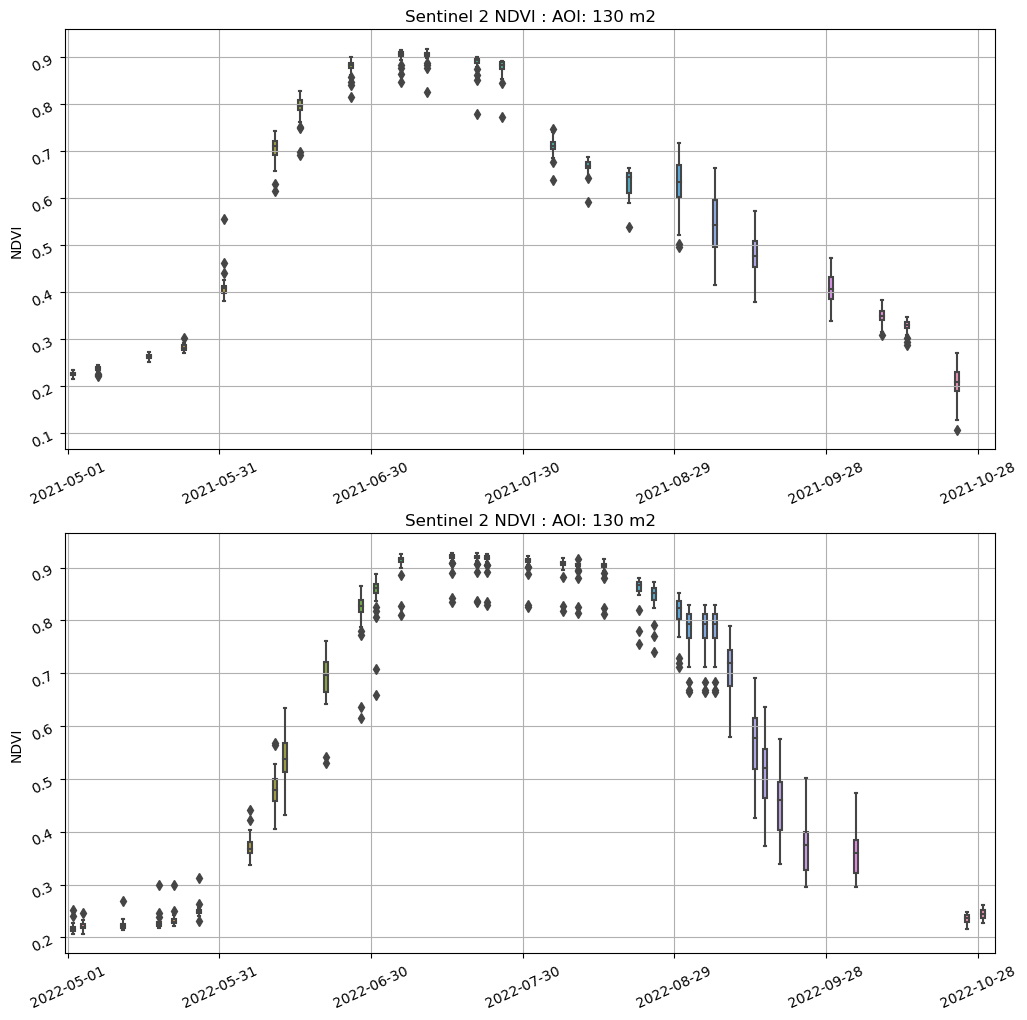

In [628]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))

s2_ndvi_full_2021_df = s2_ndvi_full_df['2021-05-01':'2021-10-31']
s2_ndvi_full_2022_df = s2_ndvi_full_df['2022-05-01':'2022-10-31']

# Make box plots.
(sns.boxplot(
    #x=s2_ndvi_df.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d')), 
    x=s2_ndvi_full_2021_df.index.strftime('%Y-%m-%d'),
    y=s2_ndvi_full_2021_df['s2_ndvi'],
    ax=ax1)
    .set(title="Sentinel 2 NDVI : AOI: 130 m2"))

(sns.boxplot(
    #x=s2_ndvi_df.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d')), 
    x=s2_ndvi_full_2022_df.index.strftime('%Y-%m-%d'),
    y=s2_ndvi_full_2022_df['s2_ndvi'],
    ax=ax2)
    .set(title="Sentinel 2 NDVI : AOI: 130 m2"))

ax1.set_ylabel('NDVI')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax1.tick_params(labelrotation=25)

ax2.set_ylabel('NDVI')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax2.tick_params(labelrotation=25)
#plt.xlim('2021-01-01', '2022-12-31')
#plt.axvspan('2022-01-01', '2022-12-31', ymin=0, ymax=1, alpha=.2)
ax1.grid()
ax2.grid()

### Extract bands and Calculate MODIS Point NDVI and populate dataframe.

In [ ]:
# Set variables for extraction function.
asset = 'surface_reflectance'
tolerance = 1000
pad = 0
r_band = 0
n_band = 1

# Get 2021 data ------
# Extract red band.
(mod_red_time_series_df) = extract_time_series(mod_items1, asset, bbox, tolerance, pad, r_band, 'red_sr')
# Extract nir band
(mod_nir_time_series_df) = extract_time_series(mod_items1, asset, bbox, tolerance, pad, n_band, 'nir_sr')
# Copute NDVI
mod1_ndvi = ((mod_nir_time_series_df['nir_sr'] - mod_red_time_series_df['red_sr']) / (mod_nir_time_series_df['nir_sr'] + mod_red_time_series_df['red_sr']))

# Get 2022 data --------
# Extract red band.
(mod_red_time_series_df) = extract_time_series(mod_items2, asset, bbox, tolerance, pad, r_band, 'red_sr')
# Extract nir band
(mod_nir_time_series_df) = extract_time_series(mod_items2, asset, bbox, tolerance, pad, n_band, 'nir_sr')
# Copute NDVI
mod2_ndvi = ((mod_nir_time_series_df['nir_sr'] - mod_red_time_series_df['red_sr']) / (mod_nir_time_series_df['nir_sr'] + mod_red_time_series_df['red_sr']))


# Give the ndvi data column an appropriate name.
var_name = "prepped_inputs_mcd43a4_corn_ndvi"
mod_ndvi_df = pd.DataFrame()
mod_ndvi_df[var_name] = mod_ndvi
mod_ndvi_df = mod_ndvi_df.set_index(pd.to_datetime(mod_ndvi_df.index).strftime('%Y-%m-%d'))

### Extract bands and Calculate Sentinel Point NDVI and populate dataframe.

In [ ]:
# Set variables for extraction function.
asset = 'surface_reflectance'
tolerance = 1000
pad = 0
r_band = 2
n_band = 6

# Extract red band.
(s2_red_time_series_df) = extract_time_series(s2_items, asset, bbox, tolerance, pad, r_band, 'red_sr')
# Extract nir band
(s2_nir_time_series_df) = extract_time_series(s2_items, asset, bbox, tolerance, pad, n_band, 'nir_sr')
# Copute NDVI
s2_ndvi = ((s2_nir_time_series_df['nir_sr'] - s2_red_time_series_df['red_sr']) / (s2_nir_time_series_df['nir_sr'] + s2_red_time_series_df['red_sr']))
        
# Give the ndvi data column an appropriate name.
var_name = "prepped_inputs_s2_ndvi"
s2_ndvi_df = pd.DataFrame()
s2_ndvi_df[var_name] = s2_ndvi
# ORIGINAL # s2_ndvi_df = s2_ndvi_df.set_index(pd.to_datetime(s2_ndvi_df.index).strftime('%Y-%m-%d'))
s2_ndvi_df

### Plot NDVi dataframe method 1.

In [ ]:
# first create a DataFrame with all dates between specified start<-->end using pd.date_range()
all_dates = pd.DataFrame(pd.date_range('2021-01-01', '2022-12-31', name='date'))
all_dates.set_index('date', inplace=True)

# from the all_dates DataFrame, left join onto the DataFrame with missing dates
#new_df = pd.merge(all_dates, s2_ndvi_df, left_index=True, right_index=True, how = 'inner')  

new_df = all_dates.merge(right=s2_ndvi_df, on='date')
new_df['prepped_inputs_s2_ndvi']
new_df.plot()
plt.xlim('2021-01-01', '2022-12-31')
plt.axvspan('2022-01-01', '2022-12-31', ymin=0, ymax=1, alpha=.2)

### Plot NDVI dataframe method 2

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(mod_ndvi_df.index, mod_ndvi_df.prepped_inputs_mcd43a4_corn_ndvi, label='prepped_inputs_mcd43a4_corn_ndvi')
ax.plot(s2_ndvi_df.index, s2_ndvi_df.prepped_inputs_s2_ndvi, label='prepped_inputs_s2_ndvi')

ax.xaxis.set_major_locator(ticker.MultipleLocator(30))

plt.xlim('2021-01-01', '2022-12-31')
plt.axvspan('2022-01-01', '2022-12-31', ymin=0, ymax=1, alpha=.2)
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Get LST for each collection/component and put into a dataframe.  Additionally, get met for the LST dates.

In [631]:
# LST collections to search.

# Dictionary keys are: var_name, tolerance, resolution, plot color.
#     var_name: used as column name in dataframe.
#     tolerance (m): search parameter in meters for extracting point data.
#     resolution (m): this is the legend when plotting
#     plot color: for plotting
#     buffer (m): for clipping.

# See https://hydrosat.github.io/fusion-hub-docs/3-FH-API-Spec.html
# for asset specifications.

# prepped_inputs_landsat = resampled to 30 m
# prepped_inputs_mod21a1d = 1000 m
# pydms_sharpened_modis = 500 m
# pydms_sharpened_landsat = downscaled to 20 m
# starfm_predictions_modis_landsat = 20 m

# ---------------------------------------------------------------------------
# USER EDITS POSSIBLE -------------------------------------------------------
# ---------------------------------------------------------------------------
asset_dict = {
    "prepped_inputs_mod21a1d" : ['mod21a1d_lst', 2000, 1000, 'brown', 500],
    "pydms_sharpened_modis" : ['pydms_modis_lst', 1000, 500, 'green', 250],
    "prepped_inputs_landsat" : ['lsat_lst', 60, 30, 'black', 65],
    "pydms_sharpened_landsat" : ['pydms_lsat_lst', 40, 20, 'blue', 65],
    "starfm_predictions_modis_landsat" : ['starfm_lst', 40, 20, 'red', 65],
}
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------

df_list = []
aoi_list = []

# Loop through the dictionary.
for i, asset in enumerate(asset_dict):

    print ("Processing {} **************************\n\n".format(asset))

    # Just to make sure these lists get reset after each loop iteration.
    found_items1 = []
    found_items2 = []
    found_items = []

    df = pd.DataFrame() # New df for lst with col name added.
    lst_df = pd.DataFrame() # df of lst with new index.
    lst_ta_df = pd.DataFrame() # df with merged LST and air temp.

    # Search and retrieve images from the two seasons.
    (found_items1, num_tiles1) = stac_tile_search(asset, geom, start1, end1)
    (found_items2, num_tiles2) = stac_tile_search(asset, geom, start2, end2)
    found_items = found_items1 + found_items2
    num_tiles = num_tiles1 + num_tiles2

    print ("    Total number of image tiles to process: {}\n".format(num_tiles))
    print ("    Extracting LST from image stack ....\n")
    
    # Extract LST data from AOI. ----------------
    try:
        (aoi_lst_da, aoi_df) = create_aoi_image_stack('lst', found_items, num_tiles, geom, asset_dict[asset][4])
    except:
        print ("Your STAC search turned up {} images.".format(num_s2_tiles))
        print ("You'll need to modify your STACsearch parameters.\n")
    
    # Save each aoi polygon in a list so we can look at them in folium later.
    aoi_list.append(aoi_df)

    print ("    Converting dataarray to dataframe ....\n")

    # Convert dataarray to dataframe.
    # Name the column to hold lst.
    col_name = "{}_lst".format(asset)
    df = aoi_lst_da.to_dataframe(name=col_name)
    # Get rid of NA dates.
    df.dropna(inplace=True)
    # Convert from multiindex to single index df.
    df = df.reset_index( level = [1 , 2, 3] )
    # Reassign the datetime to a datetime column.
    df['datetime'] = df.index
   
    # Set the index to a simple year-mon-day format.
    lst_df = df.set_index(pd.to_datetime(df.index).strftime('%Y-%m-%d'))
    # Get rid of unneeded columns.
    lst_df.drop(columns=['band','spatial_ref'], inplace=True)

    # Get met (temp) for the dates in lst_df.
    temp_df = get_ameriflux_met_dates(start1, end2, lst_df)
    lst_ta_df = lst_df.merge(temp_df, left_index=True, right_index=True)
    # Calculate CATD and create new column with values.
    lst_ta_df['catd'] = lst_ta_df[col_name].sub(lst_ta_df['TA'])

    # Merge NDVI into the df.  NDVI from above cell.
    lst_ta_ndvi_df = lst_ta_df.merge(mod_ndvi_df, left_index=True, right_index=True)

    # Create a list of dataframes.
    df_list.append(lst_ta_ndvi_df)

    print ("    Finished with {}. --------------\n".format(asset))


Processing prepped_inputs_mod21a1d **************************


    Colllection: prepped_inputs_mod21a1d 

    Number of fusion tiles available: 176


    Colllection: prepped_inputs_mod21a1d 

    Number of fusion tiles available: 168


    Total number of image tiles to process: 344

    Extracting LST from image stack ....

    Converting dataarray to dataframe ....

Reading file ../data/Ameriflux/US-Bi2_HH_201704270000_202301010000.csv
    Finished with prepped_inputs_mod21a1d. --------------

Processing pydms_sharpened_modis **************************


    Colllection: pydms_sharpened_modis 

    Number of fusion tiles available: 176


    Colllection: pydms_sharpened_modis 

    Number of fusion tiles available: 213


    Total number of image tiles to process: 389

    Extracting LST from image stack ....

    Converting dataarray to dataframe ....

Reading file ../data/Ameriflux/US-Bi2_HH_201704270000_202301010000.csv
    Finished with pydms_sharpened_modis. --------------

Pr

ERROR 1: Request for 71204810-72688818 failed with response_code=206
ERROR 1: Request for 87427128-88905542 failed with response_code=206


Reading file ../data/Ameriflux/US-Bi2_HH_201704270000_202301010000.csv
    Finished with starfm_predictions_modis_landsat. --------------



## Folium plots of AOI's used for LST extraction:
- Prepped Modis: 500 x 500 m AOI
- Sharpened Modis: 250 x 250 m AOI
- Landsat & Sentinel 2: 130 x 130 m AOI


In [632]:
# Use WGS 84 (epsg:4326) as the geographic coordinate system
#df1 = gpd.GeoDataFrame(modis_500m_aoi_df.to_crs(epsg=4326))
modis_500m_df = gpd.GeoDataFrame(aoi_list[0].to_crs(epsg=4326))
modis_250m_df = gpd.GeoDataFrame(aoi_list[2].to_crs(epsg=4326))
lsat_65m_df = gpd.GeoDataFrame(aoi_list[1].to_crs(epsg=4326))

p_geom = Point(geom['coordinates'][0], geom['coordinates'][1])

m = folium.Map(location=[p_geom.y, p_geom.x], zoom_start=15, tiles='CartoDB positron', control_scale=True)

# ---------------------------------
# Use satellite image for base map.
tile = folium.TileLayer(
    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr = 'Esri',
    name = 'Esri Satellite',
    overlay = False,
    control = True
    ).add_to(m)
# ---------------------------------

# add the polygon and centroid
for _, r in modis_500m_df.iterrows():
    # Without simplifying the representation of each polygon,
    # the map might not be displayed
    #sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    sim_geo = r[0].simplify(tolerance=0.001)
    geo_j = gpd.GeoSeries(sim_geo).to_json()
    geo_j = folium.GeoJson(data=geo_j,
                    style_function=lambda x: {'fillColor': 'orange'})

    geo_j.add_to(m)
        
    lat = sim_geo.centroid.y
    lon = sim_geo.centroid.x
    folium.Marker(location=[lat, lon]).add_to(m)

# add the polygon and centroid
for _, r in modis_250m_df.iterrows():
    # Without simplifying the representation of each polygon,
    # the map might not be displayed
    #sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    sim_geo = r[0].simplify(tolerance=0.001)
    geo_j = gpd.GeoSeries(sim_geo).to_json()
    geo_j = folium.GeoJson(data=geo_j,
                    style_function=lambda x: {'fillColor': 'orange'})

    geo_j.add_to(m)
        
    lat = sim_geo.centroid.y
    lon = sim_geo.centroid.x
    folium.Marker(location=[lat, lon]).add_to(m)

# add the polygon and centroid
for _, r in lsat_65m_df.iterrows():
    # Without simplifying the representation of each polygon,
    # the map might not be displayed
    #sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    sim_geo = r[0].simplify(tolerance=0.001)
    geo_j = gpd.GeoSeries(sim_geo).to_json()
    geo_j = folium.GeoJson(data=geo_j,
                    style_function=lambda x: {'fillColor': 'orange'})

    geo_j.add_to(m)
        
    lat = sim_geo.centroid.y
    lon = sim_geo.centroid.x
    folium.Marker(location=[lat, lon]).add_to(m)

m

## CATD box plots for each collection.
    ## - Includes CATD < 0

CATD Mean (prepped_inputs_mod21a1d): 10.827684860994982
CATD SDEV (prepped_inputs_mod21a1d): 6.119187891851353
CATD Mean (pydms_sharpened_modis): 9.784354641661352
CATD SDEV (pydms_sharpened_modis): 5.183808965315818
CATD Mean (prepped_inputs_landsat): 10.294024620056158
CATD SDEV (prepped_inputs_landsat): 4.999574798807111
CATD Mean (pydms_sharpened_landsat): 14.563736537463868
CATD SDEV (pydms_sharpened_landsat): 30.86561657080655
CATD Mean (starfm_predictions_modis_landsat): 13.524610518500918
CATD SDEV (starfm_predictions_modis_landsat): 11.611218583176072


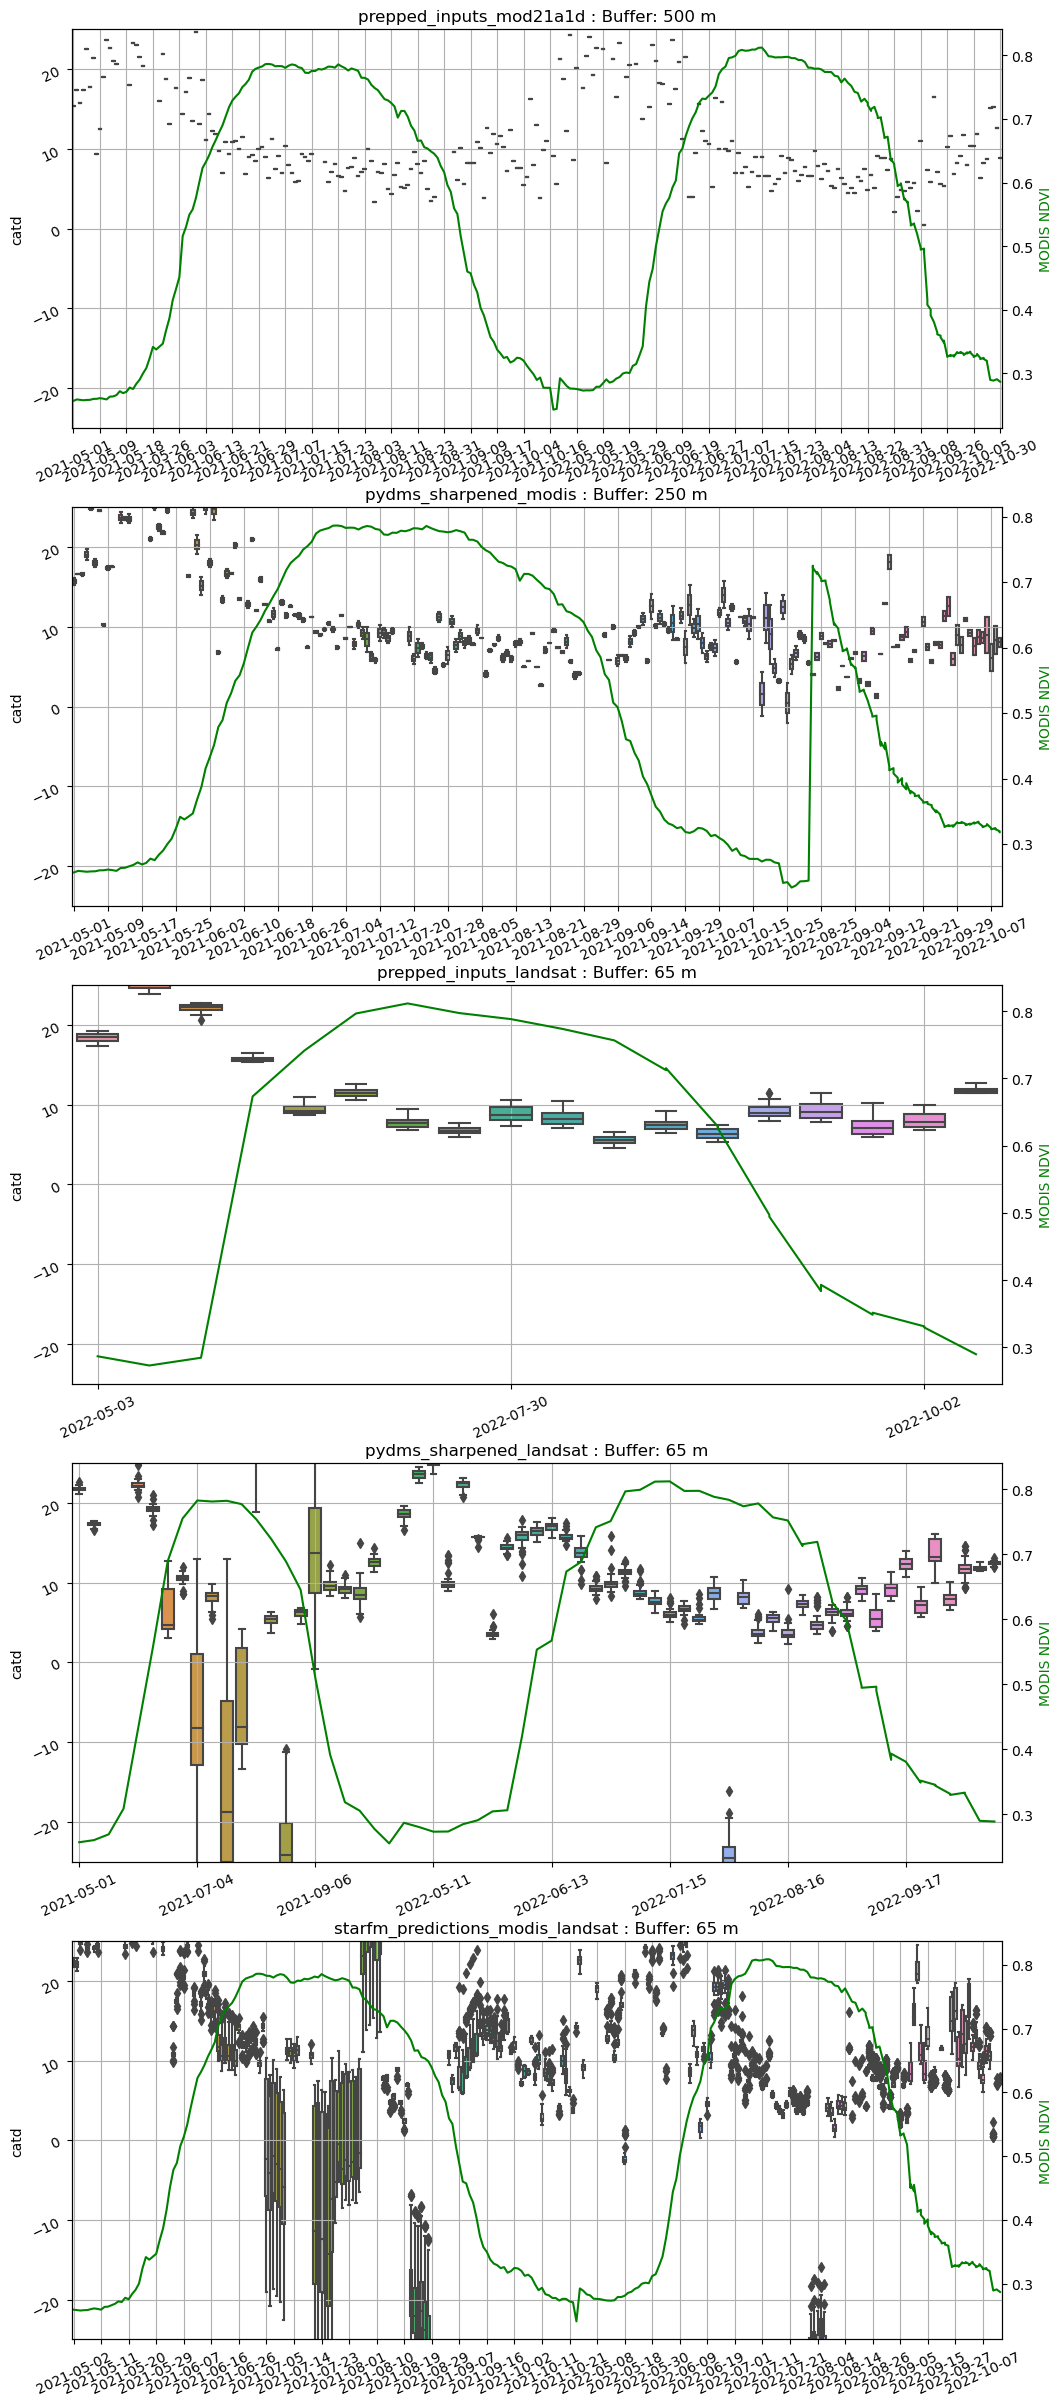

In [633]:
plt.figure(figsize=(12, 30))

# Loop through each collection in the dictionary.
for i, asset in enumerate(asset_dict):

    # add a new subplot iteratively
    ax = plt.subplot(5, 1, i + 1)
    ax2 = ax.twinx()

    # Get the dataframe out of the list.
    df = df_list[i]

    # Create a new dataframe with outliers excluded.
    # Will do this with plotting ylimits.
    # df_new = df[(df['catd'] > -25) & (df['catd'] < 25)]
    
    df_new = df
    df_new.index = pd.to_datetime(df_new.index)

    # Compute a few stats to print to screen.
    mean = df_new['catd'].abs().mean()
    sd = df_new['catd'].std()
    print ( "CATD Mean ({}): {}".format(asset, mean))
    print ( "CATD SDEV ({}): {}".format(asset, sd))

    # Make box plots.
    (sns.boxplot(
        x=df_new.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d')), 
        y=df_new['catd'],
        ax=ax)
        .set(title="{} : Buffer: {} m".format(asset, asset_dict[asset][4])))
    
    ax2.plot(
        df_new.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d')), 
        df_new['prepped_inputs_mcd43a4_corn_ndvi'],
        color="green")
    
    ax2.set_ylabel('MODIS NDVI', color='green')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
    ax.tick_params(labelrotation=25)
    ax.set_ylim(-25,25)

    ax.grid()

## CATD box plots for each collection.
    ## - Pixels with CATD < 0 are dropped.

CATD Mean (prepped_inputs_mod21a1d): 10.827684860994983
CATD SDEV (prepped_inputs_mod21a1d): 6.119187891851353
CATD Mean (pydms_sharpened_modis): 9.817643857862128
CATD SDEV (pydms_sharpened_modis): 5.14223167760085
CATD Mean (prepped_inputs_landsat): 10.294024620056158
CATD SDEV (prepped_inputs_landsat): 4.999574798807111
CATD Mean (pydms_sharpened_landsat): 11.00654090148018
CATD SDEV (pydms_sharpened_landsat): 5.958506549780806
CATD Mean (starfm_predictions_modis_landsat): 13.37091808229095
CATD SDEV (starfm_predictions_modis_landsat): 8.333355665906046


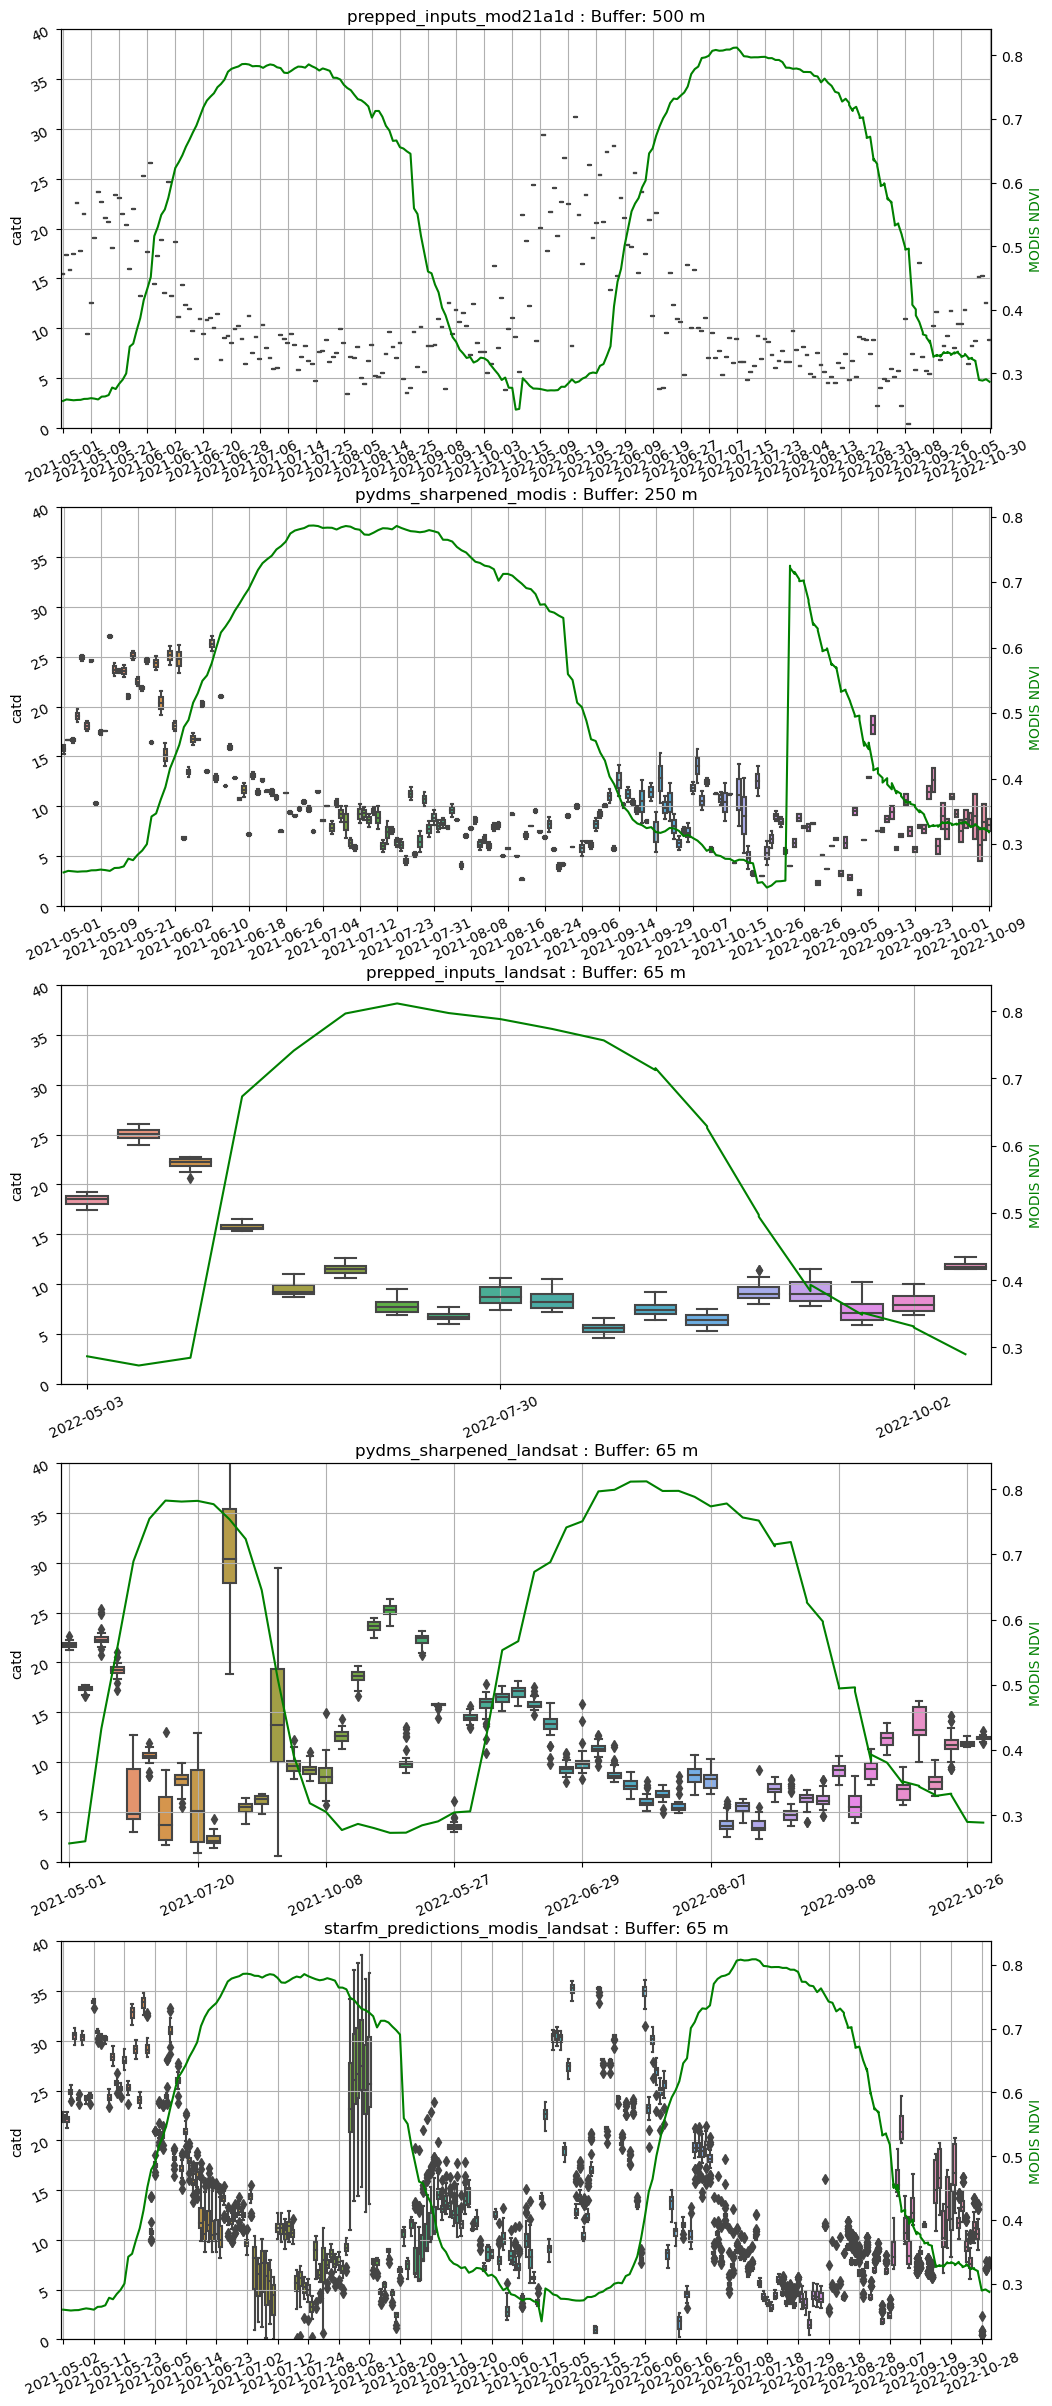

In [634]:
plt.figure(figsize=(12, 30))

# Loop through each collection in the dictionary.
for i, asset in enumerate(asset_dict):

    # add a new subplot iteratively
    ax = plt.subplot(5, 1, i + 1)
    ax2 = ax.twinx()

    # Get the dataframe out of the list.
    df = df_list[i]

    # Create a new dataframe with outliers excluded.
    # Will do this with plotting ylimits.
    df_new = df[(df['catd'] >= 0)]
    # df_new = df

    df_new.index = pd.to_datetime(df_new.index)

    # Compute a few stats to print to screen.
    mean = df_new['catd'].abs().mean()
    sd = df_new['catd'].std()
    print ( "CATD Mean ({}): {}".format(asset, mean))
    print ( "CATD SDEV ({}): {}".format(asset, sd))

    # Make box plots.
    (sns.boxplot(
        x=df_new.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d')), 
        y=df_new['catd'],
        ax=ax)
        .set(title="{} : Buffer: {} m".format(asset, asset_dict[asset][4])))
    
    ax2.plot(
        df_new.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d')), 
        df_new['prepped_inputs_mcd43a4_corn_ndvi'],
        color="green")
    
    ax2.set_ylabel('MODIS NDVI', color='green')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
    ax.tick_params(labelrotation=25)
    ax.set_ylim(0,40)

    ax.grid()

## Plot Standard Deviation and Running mean Standard Deviation
    ## - Possibly drop days with large SD

Done


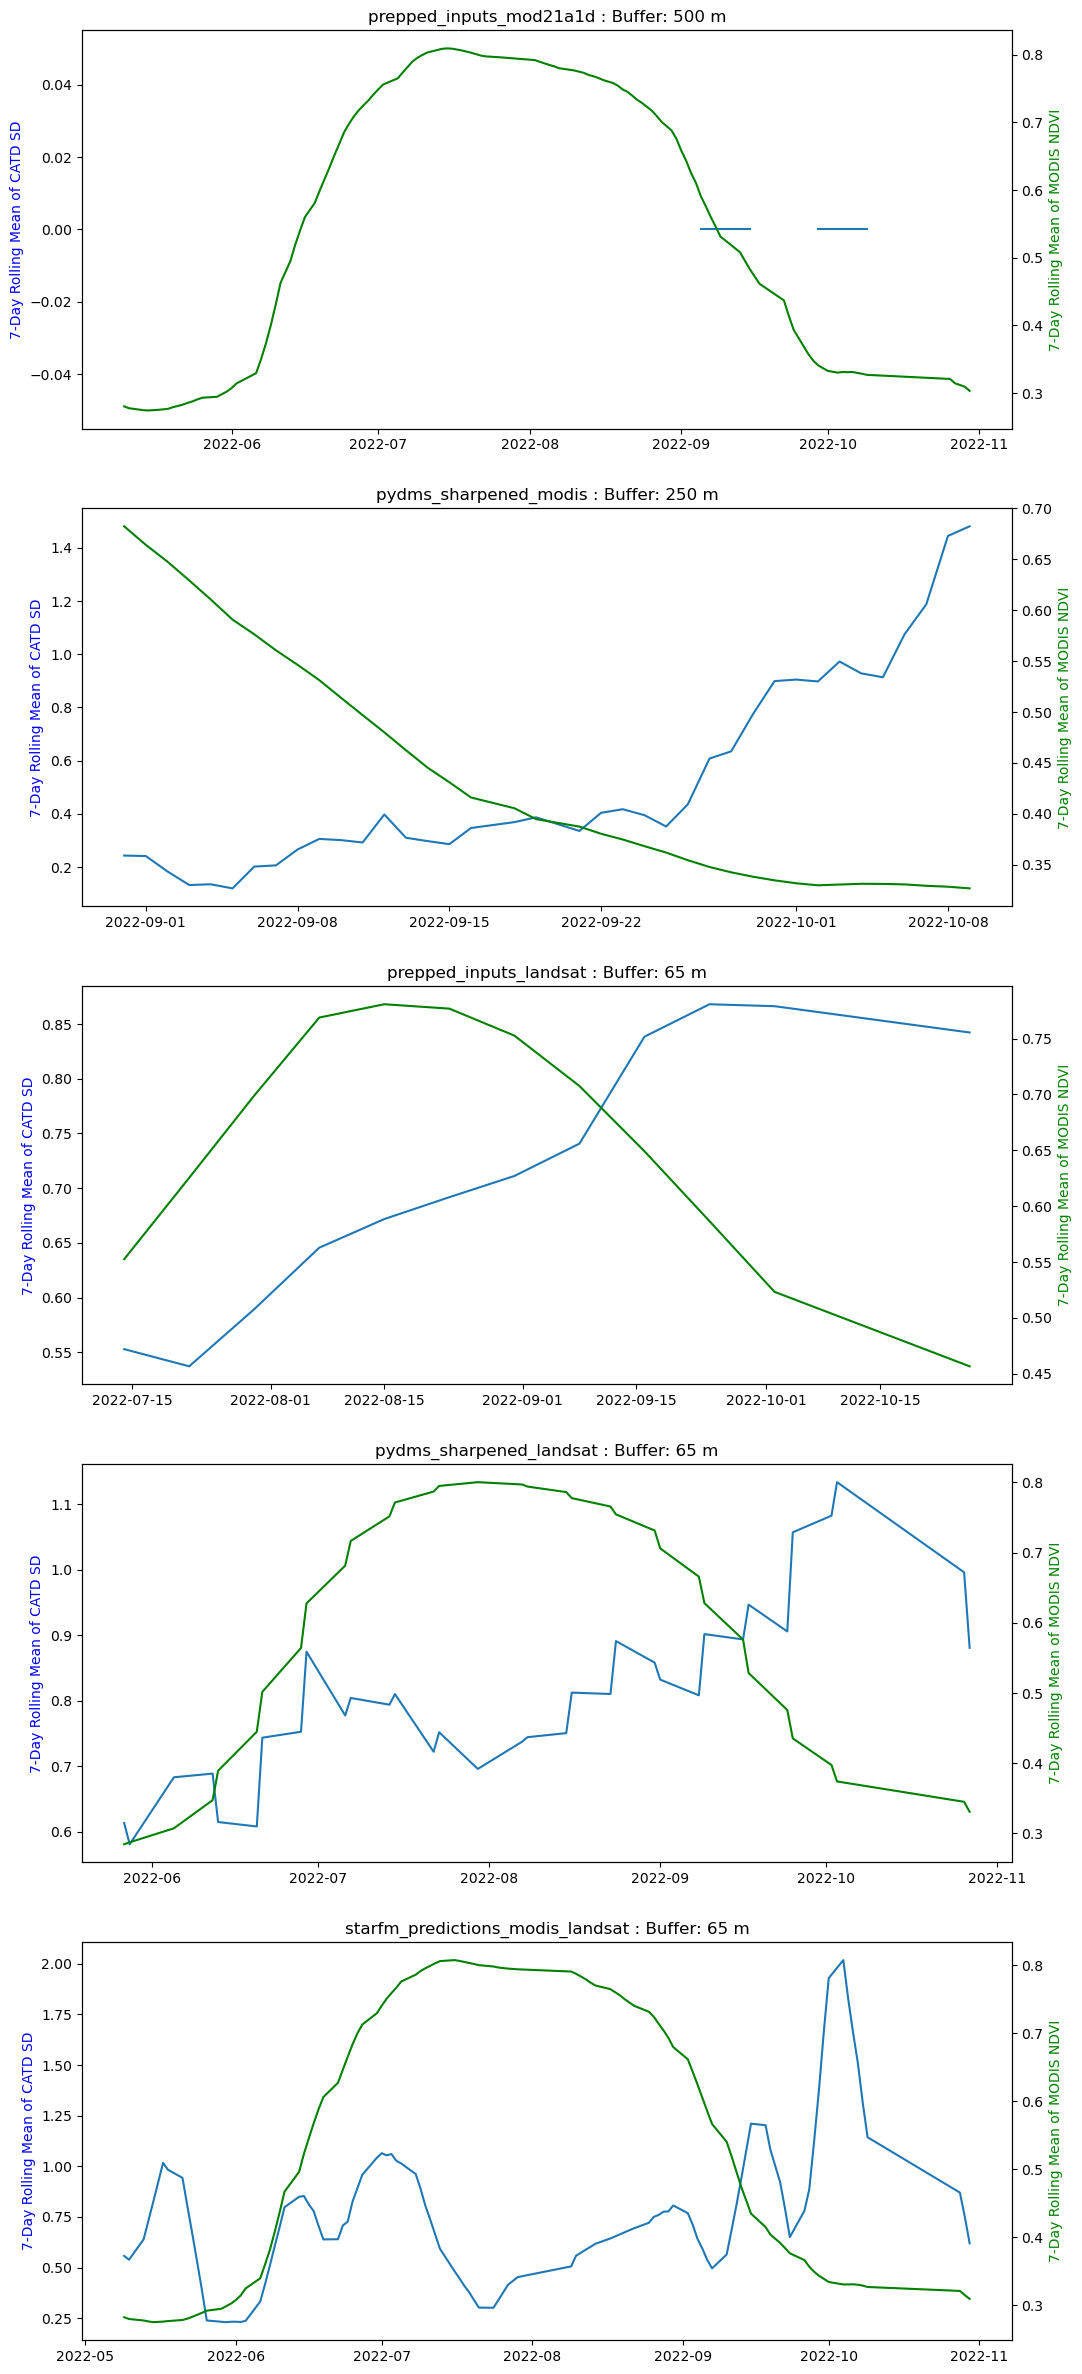

In [635]:
plt.figure(figsize=(12, 30))

# Loop through each collection in the dictionary.
for i, asset in enumerate(asset_dict):

    # add a new subplot iteratively
    ax = plt.subplot(5, 1, i + 1)
    ax2 = ax.twinx()

    # Get the dataframe out of the list.
    df = df_list[i]

    # Create a new dataframe with outliers excluded.
    # Will do this with plotting ylimits.
    df_new = df[(df['catd'] >= 0)]
    # df_new = df

    df_new.index = pd.to_datetime(df_new.index)

    # ------------------

    df_renamed1 = df_new.rename_axis("date", axis=0)
    df_renamed = df_renamed1.loc['2022-5-1':'2022-10-30']
    series_std = df_renamed.groupby([df_renamed.index.date]).catd.std()
    series_ndvi = df_renamed.groupby([df_renamed.index.date]).prepped_inputs_mcd43a4_corn_ndvi.mean()
    y1 = series_std.rolling(7).mean()
    y2 = series_ndvi.rolling(7).mean()

    ax.plot(series_std.index, y1.values)
    ax2.plot(series_ndvi.index, y2.values, color='green')

    ax.set_ylabel('7-Day Rolling Mean of CATD SD', color='blue')
    ax2.set_ylabel('7-Day Rolling Mean of MODIS NDVI', color='green')
    ax.set_title("{} : Buffer: {} m".format(asset, asset_dict[asset][4]))
    # ------------------

"""
    # Make box plots.
    (sns.boxplot(
        x=df_new.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d')), 
        y=df_new['catd'],
        ax=ax)
        .set(title="{} : Buffer: {} m".format(asset, asset_dict[asset][4])))
    
    ax2.plot(
        df_new.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d')), 
        df_new['prepped_inputs_mcd43a4_corn_ndvi'],
        color="green")
    
    ax2.set_ylabel('MODIS NDVI', color='green')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
    ax.tick_params(labelrotation=25)
    ax.set_ylim(-25,25)

    ax.grid()
"""
print ("Done")

## What are the dates of the "landsat_sharpened" outliers?

In [225]:
df = df_list[3] 
outliers_df = df[(df['catd'] < -5)]
pd.unique(outliers_df.index)

array(['2021-07-04T00:00:00.000000000', '2021-07-20T00:00:00.000000000',
       '2021-07-27T00:00:00.000000000', '2021-08-21T00:00:00.000000000',
       '2021-10-24T00:00:00.000000000', '2022-07-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

## Scatterplots of CATD vs NDVI for each Collection/Component.

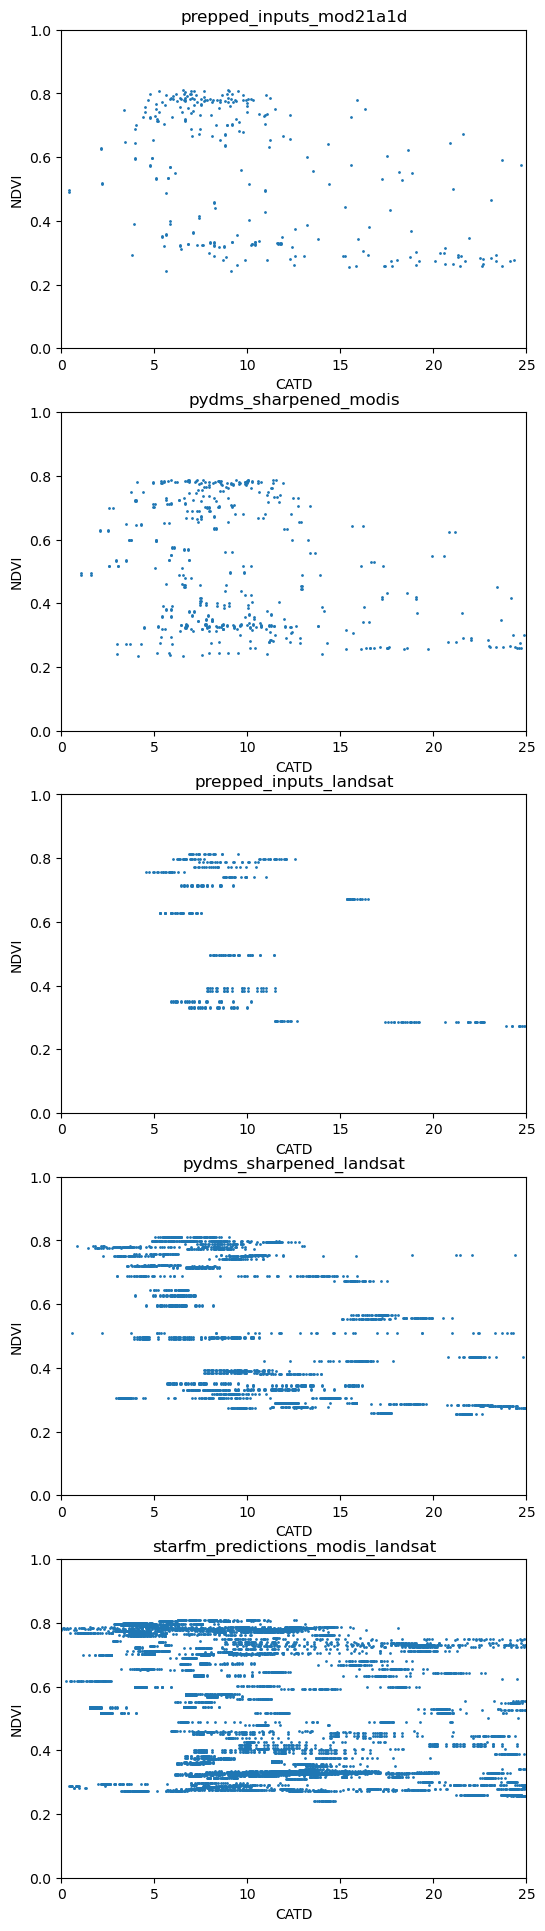

In [636]:
plt.figure(figsize=(6, 24))

# Loop through each collection in the dictionary.
for i, asset in enumerate(asset_dict):

    # add a new subplot iteratively
    ax = plt.subplot(5, 1, i + 1)

    # --------------------------------------------------
    df = df_list[i]
    df.index = pd.to_datetime(df.index)

    df_new = df[(df['catd'] > -25) & (df['catd'] < 25)]
    df_new.index = pd.to_datetime(df_new.index)

    ax.scatter(df_new['catd'], df_new['prepped_inputs_mcd43a4_corn_ndvi'], s=1)
    
    ax.set_xlim(0,25)
    ax.set_ylim(0,1)
    ax.set_title(label=asset)
    ax.set_xlabel('CATD')
    ax.set_ylabel('NDVI')